In [8]:
# !pip install --upgrade ta


In [9]:
from config import API_KEY
import pandas as pd,plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"
import sweetviz as sv
import plotly.express as px

from ta.trend import MACD as md
import pandas as pd
import ta
from ta.utils import dropna
import pycaret 


In [10]:
pycaret.__version__

'3.0.0'

Obtaining Data

In [11]:
# Data Collection
from tiingo import TiingoClient
from datetime import datetime, timedelta

config = {
    'api_key': API_KEY,
    'session': True  # Use requests.Session
}
client = TiingoClient(config)

# Calculate the start date as today's date minus 2 years
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

# Convert dates to string format
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

df = client.get_dataframe('MSFT', frequency='daily',startDate=start_date_str, endDate=end_date_str)

df.head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,
2019-02-27 00:00:00+00:00,112.17,112.36,110.88,111.69,21487062,106.757103,106.937935,105.529354,106.300266,21487062,0.0,1.0
2019-02-28 00:00:00+00:00,112.03,112.88,111.73,112.04,29083934,106.623859,107.432842,106.338336,106.633377,29083934,0.0,1.0
2019-03-01 00:00:00+00:00,112.53,113.02,111.67,112.89,23501169,107.099731,107.566086,106.281232,107.442359,23501169,0.0,1.0
2019-03-04 00:00:00+00:00,112.26,113.25,110.80,113.02,26608014,106.842760,107.784987,105.453214,107.566086,26608014,0.0,1.0
2019-03-05 00:00:00+00:00,111.70,112.39,111.23,112.25,19538318,106.309784,106.966487,105.862464,106.833243,19538318,0.0,1.0


In [12]:
df.reset_index(inplace=True)
df.rename(columns={'index': 'new_index'}, inplace=True)  # Rename the old index column
df['date'] = df['date'].dt.date  # Extract the date part from the datetime index
df

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2019-02-27,112.17,112.36,110.88,111.690,21487062,106.757103,106.937935,105.529354,106.300266,21487062,0.0,1.0
1,2019-02-28,112.03,112.88,111.73,112.040,29083934,106.623859,107.432842,106.338336,106.633377,29083934,0.0,1.0
2,2019-03-01,112.53,113.02,111.67,112.890,23501169,107.099731,107.566086,106.281232,107.442359,23501169,0.0,1.0
3,2019-03-04,112.26,113.25,110.80,113.020,26608014,106.842760,107.784987,105.453214,107.566086,26608014,0.0,1.0
4,2019-03-05,111.70,112.39,111.23,112.250,19538318,106.309784,106.966487,105.862464,106.833243,19538318,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2024-02-20,402.79,404.49,398.01,403.240,24307915,402.790000,404.490000,398.010000,403.240000,24307915,0.0,1.0
1254,2024-02-21,402.18,402.29,397.22,400.170,18631072,402.180000,402.290000,397.220000,400.170000,18631072,0.0,1.0
1255,2024-02-22,411.65,412.83,408.57,410.190,27009869,411.650000,412.830000,408.570000,410.190000,27009869,0.0,1.0
1256,2024-02-23,410.34,415.86,408.97,415.670,16295879,410.340000,415.860000,408.970000,415.670000,16295879,0.0,1.0


Exploratory Analysis

Removing Columns

In [13]:
# Removing 'Dividends' and 'Stock Splits' columns
df = df.drop(['divCash', 'splitFactor','close','high','low', 'open', 'volume','adjVolume'], axis = 1)
# See results
df

,date,adjClose,adjHigh,adjLow,adjOpen
0,2019-02-27,106.757103,106.937935,105.529354,106.300266
1,2019-02-28,106.623859,107.432842,106.338336,106.633377
2,2019-03-01,107.099731,107.566086,106.281232,107.442359
3,2019-03-04,106.842760,107.784987,105.453214,107.566086
4,2019-03-05,106.309784,106.966487,105.862464,106.833243
...,...,...,...,...,...
1253,2024-02-20,402.790000,404.490000,398.010000,403.240000
1254,2024-02-21,402.180000,402.290000,397.220000,400.170000
1255,2024-02-22,411.650000,412.830000,408.570000,410.190000
1256,2024-02-23,410.340000,415.860000,408.970000,415.670000


In [14]:
# # # Creating a new dataframe containing the last 2 years data to later test how well our predicting model will compare to the closing prices
# df_predict = df.tail(506)
# # See results
# df_predict


# Calculate MACD
# macd_indicator = ta.trend.MACD(close=df['adjClose'], window_slow=26, window_fast=12, window_sign=9)

# Add MACD line to dataframe
# df['MACD'] = macd_indicator.macd()

# # Add MACD signal line to dataframe
# df['MACD_signal'] = macd_indicator.macd_signal()

# # Add MACD histogram to dataframe
# df['MACD_histogram'] = macd_indicator.macd_diff()

# Display the updated dataframe
df

,date,adjClose,adjHigh,adjLow,adjOpen
0,2019-02-27,106.757103,106.937935,105.529354,106.300266
1,2019-02-28,106.623859,107.432842,106.338336,106.633377
2,2019-03-01,107.099731,107.566086,106.281232,107.442359
3,2019-03-04,106.842760,107.784987,105.453214,107.566086
4,2019-03-05,106.309784,106.966487,105.862464,106.833243
...,...,...,...,...,...
1253,2024-02-20,402.790000,404.490000,398.010000,403.240000
1254,2024-02-21,402.180000,402.290000,397.220000,400.170000
1255,2024-02-22,411.650000,412.830000,408.570000,410.190000
1256,2024-02-23,410.340000,415.860000,408.970000,415.670000


In [15]:
# # # Removing last 2 years from the original dataframe
# df.drop(df_predict.index,inplace = True)
# # See results
# df

In [16]:
# Removing NaN
df.dropna(inplace=True)
# See Results
df

,date,adjClose,adjHigh,adjLow,adjOpen
0,2019-02-27,106.757103,106.937935,105.529354,106.300266
1,2019-02-28,106.623859,107.432842,106.338336,106.633377
2,2019-03-01,107.099731,107.566086,106.281232,107.442359
3,2019-03-04,106.842760,107.784987,105.453214,107.566086
4,2019-03-05,106.309784,106.966487,105.862464,106.833243
...,...,...,...,...,...
1253,2024-02-20,402.790000,404.490000,398.010000,403.240000
1254,2024-02-21,402.180000,402.290000,397.220000,400.170000
1255,2024-02-22,411.650000,412.830000,408.570000,410.190000
1256,2024-02-23,410.340000,415.860000,408.970000,415.670000


In [17]:
# Create an RSI indicator instance using the adjusted close column
# rsi_indicator = ta.momentum.RSIIndicator(close=df['adjClose'], window=14)

# Calculate the RSI and add it to the dataframe
# df['RSI'] = rsi_indicator.rsi()
# df

<AxesSubplot: >

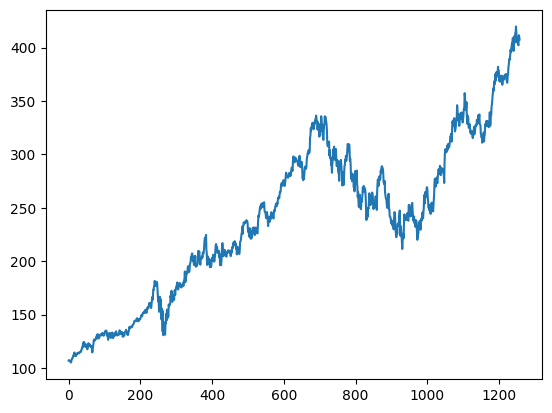

In [18]:
df.adjClose.plot()

In [19]:
# Calculate the differences for every column except for the RSI column
# df_diff = df.drop(columns=['RSI','MACD','MACD_signal','MACD_histogram']).diff().dropna()

# Calculate the RSI using the adjusted close column
rsi_indicator = ta.momentum.RSIIndicator(close=df['adjOpen'], window=14)
df['RSI'] = rsi_indicator.rsi()

# Concatenate the differenced data with the RSI column
# diffs = pd.concat([df_diff, df[['RSI','MACD','MACD_signal','MACD_histogram']]], axis=1)


df_diff = df.drop(columns=['RSI']).diff().dropna()


diffs = pd.concat([df_diff, df[['RSI']]], axis=1)

# Display the resulting dataframe
diffs

,date,adjClose,adjHigh,adjLow,adjOpen,RSI
1,"1 day, 0:00:00",-0.133244,0.494907,0.808982,0.333110,NaN
2,"1 day, 0:00:00",0.475872,0.133244,-0.057105,0.808982,NaN
3,"3 days, 0:00:00",-0.256971,0.218901,-0.828017,0.123727,NaN
4,"1 day, 0:00:00",-0.532977,-0.818500,0.409250,-0.732843,NaN
5,"1 day, 0:00:00",0.047587,0.256971,0.190349,-0.361663,NaN
...,...,...,...,...,...,...
1254,"1 day, 0:00:00",-0.610000,-2.200000,-0.790000,-3.070000,49.344387
1255,"1 day, 0:00:00",9.470000,10.540000,11.350000,10.020000,57.606315
1256,"1 day, 0:00:00",-1.310000,3.030000,0.400000,5.480000,61.321816
1257,"3 days, 0:00:00",-2.800000,-3.700000,-1.610000,-4.215000,57.171354


In [20]:
# diffs= df.diff()

<AxesSubplot: >

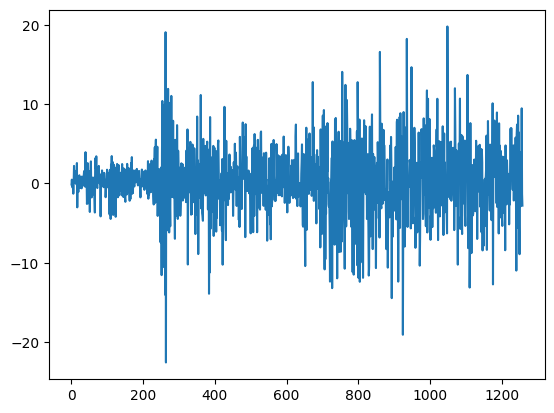

In [21]:
diffs.adjClose.plot()

In [22]:
diffs.corr()

,adjClose,adjHigh,adjLow,adjOpen,RSI
adjClose,1.000000,0.688544,0.694597,0.283097,0.079203
adjHigh,0.688544,1.000000,0.719940,0.694127,0.238405
adjLow,0.694597,0.719940,1.000000,0.710510,0.217011
adjOpen,0.283097,0.694127,0.710510,1.000000,0.325804
RSI,0.079203,0.238405,0.217011,0.325804,1.000000


In [23]:
# Assuming your data is sorted by time
# Create a lag feature to represent the previous values
for i in range(1, 6):  # Assuming you want to use the first 15 points to predict the next one
    diffs[f'adjCloseLag_{i}'] = diffs['adjClose'].shift(i)

for i in range(1, 6):  # Assuming you want to use the first 15 points to predict the next one
    diffs[f'adjHighlag_{i}'] = diffs['adjHigh'].shift(i)

for i in range(1, 6):  # Assuming you want to use the first 15 points to predict the next one
    diffs[f'adjLowlag_{i}'] = diffs['adjLow'].shift(i)

for i in range(1, 6):  # Assuming you want to use the first 15 points to predict the next one
    diffs[f'adjOpenlag_{i}'] = diffs['adjOpen'].shift(i)



In [24]:
diffs.head(10)

,date,adjClose,adjHigh,adjLow,adjOpen,RSI,adjCloseLag_1,adjCloseLag_2,adjCloseLag_3,adjCloseLag_4,...,adjLowlag_1,adjLowlag_2,adjLowlag_3,adjLowlag_4,adjLowlag_5,adjOpenlag_1,adjOpenlag_2,adjOpenlag_3,adjOpenlag_4,adjOpenlag_5
1,"1 day, 0:00:00",-0.133244,0.494907,0.808982,0.333110,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"1 day, 0:00:00",0.475872,0.133244,-0.057105,0.808982,NaN,-0.133244,NaN,NaN,NaN,...,0.808982,NaN,NaN,NaN,NaN,0.333110,NaN,NaN,NaN,NaN
3,"3 days, 0:00:00",-0.256971,0.218901,-0.828017,0.123727,NaN,0.475872,-0.133244,NaN,NaN,...,-0.057105,0.808982,NaN,NaN,NaN,0.808982,0.333110,NaN,NaN,NaN
4,"1 day, 0:00:00",-0.532977,-0.818500,0.409250,-0.732843,NaN,-0.256971,0.475872,-0.133244,NaN,...,-0.828017,-0.057105,0.808982,NaN,NaN,0.123727,0.808982,0.333110,NaN,NaN
5,"1 day, 0:00:00",0.047587,0.256971,0.190349,-0.361663,NaN,-0.532977,-0.256971,0.475872,-0.133244,...,0.409250,-0.828017,-0.057105,0.808982,NaN,-0.732843,0.123727,0.808982,0.333110,NaN
6,"1 day, 0:00:00",-1.294372,-1.056436,-1.484720,-0.447320,NaN,0.047587,-0.532977,-0.256971,0.475872,...,0.190349,0.409250,-0.828017,-0.057105,0.808982,-0.361663,-0.732843,0.123727,0.808982,0.333110
7,"1 day, 0:00:00",0.114209,-0.799465,-1.018366,-2.131906,NaN,-1.294372,0.047587,-0.532977,-0.256971,...,-1.484720,0.190349,0.409250,-0.828017,-0.057105,-0.447320,-0.361663,-0.732843,0.123727,0.808982
8,"3 days, 0:00:00",2.208046,2.131906,2.074802,1.741691,NaN,0.114209,-1.294372,0.047587,-0.532977,...,-1.018366,-1.484720,0.190349,0.409250,-0.828017,-2.131906,-0.447320,-0.361663,-0.732843,0.123727
9,"1 day, 0:00:00",0.751878,0.989814,1.589412,1.741691,NaN,2.208046,0.114209,-1.294372,0.047587,...,2.074802,-1.018366,-1.484720,0.190349,0.409250,1.741691,-2.131906,-0.447320,-0.361663,-0.732843
10,"1 day, 0:00:00",0.837535,0.961261,1.075471,1.246784,NaN,0.751878,2.208046,0.114209,-1.294372,...,1.589412,2.074802,-1.018366,-1.484720,0.190349,1.741691,1.741691,-2.131906,-0.447320,-0.361663


In [25]:
diffs['date'] = df['date']
diffs

,date,adjClose,adjHigh,adjLow,adjOpen,RSI,adjCloseLag_1,adjCloseLag_2,adjCloseLag_3,adjCloseLag_4,...,adjLowlag_1,adjLowlag_2,adjLowlag_3,adjLowlag_4,adjLowlag_5,adjOpenlag_1,adjOpenlag_2,adjOpenlag_3,adjOpenlag_4,adjOpenlag_5
1,2019-02-28,-0.133244,0.494907,0.808982,0.333110,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-03-01,0.475872,0.133244,-0.057105,0.808982,NaN,-0.133244,NaN,NaN,NaN,...,0.808982,NaN,NaN,NaN,NaN,0.333110,NaN,NaN,NaN,NaN
3,2019-03-04,-0.256971,0.218901,-0.828017,0.123727,NaN,0.475872,-0.133244,NaN,NaN,...,-0.057105,0.808982,NaN,NaN,NaN,0.808982,0.333110,NaN,NaN,NaN
4,2019-03-05,-0.532977,-0.818500,0.409250,-0.732843,NaN,-0.256971,0.475872,-0.133244,NaN,...,-0.828017,-0.057105,0.808982,NaN,NaN,0.123727,0.808982,0.333110,NaN,NaN
5,2019-03-06,0.047587,0.256971,0.190349,-0.361663,NaN,-0.532977,-0.256971,0.475872,-0.133244,...,0.409250,-0.828017,-0.057105,0.808982,NaN,-0.732843,0.123727,0.808982,0.333110,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2024-02-21,-0.610000,-2.200000,-0.790000,-3.070000,49.344387,-1.270000,-2.500000,-2.930000,3.912833,...,-5.430000,-0.850000,-0.280000,1.917477,-11.339232,-4.720000,-0.180000,0.070000,3.870311,-15.586453
1255,2024-02-22,9.470000,10.540000,11.350000,10.020000,57.606315,-0.610000,-1.270000,-2.500000,-2.930000,...,-0.790000,-5.430000,-0.850000,-0.280000,1.917477,-3.070000,-4.720000,-0.180000,0.070000,3.870311
1256,2024-02-23,-1.310000,3.030000,0.400000,5.480000,61.321816,9.470000,-0.610000,-1.270000,-2.500000,...,11.350000,-0.790000,-5.430000,-0.850000,-0.280000,10.020000,-3.070000,-4.720000,-0.180000,0.070000
1257,2024-02-26,-2.800000,-3.700000,-1.610000,-4.215000,57.171354,-1.310000,9.470000,-0.610000,-1.270000,...,0.400000,11.350000,-0.790000,-5.430000,-0.850000,5.480000,10.020000,-3.070000,-4.720000,-0.180000


In [26]:
diffs = diffs.drop(0)
diffs

,date,adjClose,adjHigh,adjLow,adjOpen,RSI,adjCloseLag_1,adjCloseLag_2,adjCloseLag_3,adjCloseLag_4,...,adjLowlag_1,adjLowlag_2,adjLowlag_3,adjLowlag_4,adjLowlag_5,adjOpenlag_1,adjOpenlag_2,adjOpenlag_3,adjOpenlag_4,adjOpenlag_5
1,2019-02-28,-0.133244,0.494907,0.808982,0.333110,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-03-01,0.475872,0.133244,-0.057105,0.808982,NaN,-0.133244,NaN,NaN,NaN,...,0.808982,NaN,NaN,NaN,NaN,0.333110,NaN,NaN,NaN,NaN
3,2019-03-04,-0.256971,0.218901,-0.828017,0.123727,NaN,0.475872,-0.133244,NaN,NaN,...,-0.057105,0.808982,NaN,NaN,NaN,0.808982,0.333110,NaN,NaN,NaN
4,2019-03-05,-0.532977,-0.818500,0.409250,-0.732843,NaN,-0.256971,0.475872,-0.133244,NaN,...,-0.828017,-0.057105,0.808982,NaN,NaN,0.123727,0.808982,0.333110,NaN,NaN
5,2019-03-06,0.047587,0.256971,0.190349,-0.361663,NaN,-0.532977,-0.256971,0.475872,-0.133244,...,0.409250,-0.828017,-0.057105,0.808982,NaN,-0.732843,0.123727,0.808982,0.333110,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2024-02-20,-1.270000,-3.800000,-5.430000,-4.720000,52.240910,-2.500000,-2.930000,3.912833,-8.923656,...,-0.850000,-0.280000,1.917477,-11.339232,-0.339378,-0.180000,0.070000,3.870311,-15.586453,5.295301
1254,2024-02-21,-0.610000,-2.200000,-0.790000,-3.070000,49.344387,-1.270000,-2.500000,-2.930000,3.912833,...,-5.430000,-0.850000,-0.280000,1.917477,-11.339232,-4.720000,-0.180000,0.070000,3.870311,-15.586453
1255,2024-02-22,9.470000,10.540000,11.350000,10.020000,57.606315,-0.610000,-1.270000,-2.500000,-2.930000,...,-0.790000,-5.430000,-0.850000,-0.280000,1.917477,-3.070000,-4.720000,-0.180000,0.070000,3.870311
1256,2024-02-23,-1.310000,3.030000,0.400000,5.480000,61.321816,9.470000,-0.610000,-1.270000,-2.500000,...,11.350000,-0.790000,-5.430000,-0.850000,-0.280000,10.020000,-3.070000,-4.720000,-0.180000,0.070000


In [27]:
diffs.dropna()

,date,adjClose,adjHigh,adjLow,adjOpen,RSI,adjCloseLag_1,adjCloseLag_2,adjCloseLag_3,adjCloseLag_4,...,adjLowlag_1,adjLowlag_2,adjLowlag_3,adjLowlag_4,adjLowlag_5,adjOpenlag_1,adjOpenlag_2,adjOpenlag_3,adjOpenlag_4,adjOpenlag_5
13,2019-03-18,1.579895,0.342628,1.389546,0.789947,72.701068,1.256302,0.085657,0.837535,0.751878,...,0.247453,0.523459,1.075471,1.589412,2.074802,0.761395,0.390215,1.246784,1.741691,1.741691
14,2019-03-19,0.076140,0.789947,0.894639,1.827348,78.041372,1.579895,1.256302,0.085657,0.837535,...,1.389546,0.247453,0.523459,1.075471,1.589412,0.789947,0.761395,0.390215,1.246784,1.741691
15,2019-03-20,-0.123727,0.295041,-0.266488,-0.666221,72.474788,0.076140,1.579895,1.256302,0.085657,...,0.894639,1.389546,0.247453,0.523459,1.075471,1.827348,0.789947,0.761395,0.390215,1.246784
16,2019-03-21,2.569708,1.970110,0.361663,-0.237936,70.539599,-0.123727,0.076140,1.579895,1.256302,...,-0.266488,0.894639,1.389546,0.247453,0.523459,-0.666221,1.827348,0.789947,0.761395,0.390215
17,2019-03-22,-3.017028,-1.170645,-0.047587,2.246115,76.829327,2.569708,-0.123727,0.076140,1.579895,...,0.361663,-0.266488,0.894639,1.389546,0.247453,-0.237936,-0.666221,1.827348,0.789947,0.761395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2024-02-20,-1.270000,-3.800000,-5.430000,-4.720000,52.240910,-2.500000,-2.930000,3.912833,-8.923656,...,-0.850000,-0.280000,1.917477,-11.339232,-0.339378,-0.180000,0.070000,3.870311,-15.586453,5.295301
1254,2024-02-21,-0.610000,-2.200000,-0.790000,-3.070000,49.344387,-1.270000,-2.500000,-2.930000,3.912833,...,-5.430000,-0.850000,-0.280000,1.917477,-11.339232,-4.720000,-0.180000,0.070000,3.870311,-15.586453
1255,2024-02-22,9.470000,10.540000,11.350000,10.020000,57.606315,-0.610000,-1.270000,-2.500000,-2.930000,...,-0.790000,-5.430000,-0.850000,-0.280000,1.917477,-3.070000,-4.720000,-0.180000,0.070000,3.870311
1256,2024-02-23,-1.310000,3.030000,0.400000,5.480000,61.321816,9.470000,-0.610000,-1.270000,-2.500000,...,11.350000,-0.790000,-5.430000,-0.850000,-0.280000,10.020000,-3.070000,-4.720000,-0.180000,0.070000


In [28]:
import numpy as np
diffs['target'] =np.where(diffs.adjClose >=0 ,1,0 )
diffs.head()
diffs.dropna(inplace=True)

In [29]:
# diffs['target']=diffs['target'].shift(1)
diffs

,date,adjClose,adjHigh,adjLow,adjOpen,RSI,adjCloseLag_1,adjCloseLag_2,adjCloseLag_3,adjCloseLag_4,...,adjLowlag_2,adjLowlag_3,adjLowlag_4,adjLowlag_5,adjOpenlag_1,adjOpenlag_2,adjOpenlag_3,adjOpenlag_4,adjOpenlag_5,target
13,2019-03-18,1.579895,0.342628,1.389546,0.789947,72.701068,1.256302,0.085657,0.837535,0.751878,...,0.523459,1.075471,1.589412,2.074802,0.761395,0.390215,1.246784,1.741691,1.741691,1
14,2019-03-19,0.076140,0.789947,0.894639,1.827348,78.041372,1.579895,1.256302,0.085657,0.837535,...,0.247453,0.523459,1.075471,1.589412,0.789947,0.761395,0.390215,1.246784,1.741691,1
15,2019-03-20,-0.123727,0.295041,-0.266488,-0.666221,72.474788,0.076140,1.579895,1.256302,0.085657,...,1.389546,0.247453,0.523459,1.075471,1.827348,0.789947,0.761395,0.390215,1.246784,0
16,2019-03-21,2.569708,1.970110,0.361663,-0.237936,70.539599,-0.123727,0.076140,1.579895,1.256302,...,0.894639,1.389546,0.247453,0.523459,-0.666221,1.827348,0.789947,0.761395,0.390215,1
17,2019-03-22,-3.017028,-1.170645,-0.047587,2.246115,76.829327,2.569708,-0.123727,0.076140,1.579895,...,-0.266488,0.894639,1.389546,0.247453,-0.237936,-0.666221,1.827348,0.789947,0.761395,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2024-02-20,-1.270000,-3.800000,-5.430000,-4.720000,52.240910,-2.500000,-2.930000,3.912833,-8.923656,...,-0.280000,1.917477,-11.339232,-0.339378,-0.180000,0.070000,3.870311,-15.586453,5.295301,0
1254,2024-02-21,-0.610000,-2.200000,-0.790000,-3.070000,49.344387,-1.270000,-2.500000,-2.930000,3.912833,...,-0.850000,-0.280000,1.917477,-11.339232,-4.720000,-0.180000,0.070000,3.870311,-15.586453,0
1255,2024-02-22,9.470000,10.540000,11.350000,10.020000,57.606315,-0.610000,-1.270000,-2.500000,-2.930000,...,-5.430000,-0.850000,-0.280000,1.917477,-3.070000,-4.720000,-0.180000,0.070000,3.870311,1
1256,2024-02-23,-1.310000,3.030000,0.400000,5.480000,61.321816,9.470000,-0.610000,-1.270000,-2.500000,...,-0.790000,-5.430000,-0.850000,-0.280000,10.020000,-3.070000,-4.720000,-0.180000,0.070000,0


In [30]:
diffs.columns

Index(['date', 'adjClose', 'adjHigh', 'adjLow', 'adjOpen', 'RSI',
       'adjCloseLag_1', 'adjCloseLag_2', 'adjCloseLag_3', 'adjCloseLag_4',
       'adjCloseLag_5', 'adjHighlag_1', 'adjHighlag_2', 'adjHighlag_3',
       'adjHighlag_4', 'adjHighlag_5', 'adjLowlag_1', 'adjLowlag_2',
       'adjLowlag_3', 'adjLowlag_4', 'adjLowlag_5', 'adjOpenlag_1',
       'adjOpenlag_2', 'adjOpenlag_3', 'adjOpenlag_4', 'adjOpenlag_5',
       'target'],
      dtype='object')

In [31]:
diffs.drop(['adjHigh', 'adjLow'],axis=1,inplace=True)
diffs.head()


,date,adjClose,adjOpen,RSI,adjCloseLag_1,adjCloseLag_2,adjCloseLag_3,adjCloseLag_4,adjCloseLag_5,adjHighlag_1,...,adjLowlag_2,adjLowlag_3,adjLowlag_4,adjLowlag_5,adjOpenlag_1,adjOpenlag_2,adjOpenlag_3,adjOpenlag_4,adjOpenlag_5,target
13,2019-03-18,1.579895,0.789947,72.701068,1.256302,0.085657,0.837535,0.751878,2.208046,1.951075,...,0.523459,1.075471,1.589412,2.074802,0.761395,0.390215,1.246784,1.741691,1.741691,1
14,2019-03-19,0.076140,1.827348,78.041372,1.579895,1.256302,0.085657,0.837535,0.751878,0.342628,...,0.247453,0.523459,1.075471,1.589412,0.789947,0.761395,0.390215,1.246784,1.741691,1
15,2019-03-20,-0.123727,-0.666221,72.474788,0.076140,1.579895,1.256302,0.085657,0.837535,0.789947,...,1.389546,0.247453,0.523459,1.075471,1.827348,0.789947,0.761395,0.390215,1.246784,0
16,2019-03-21,2.569708,-0.237936,70.539599,-0.123727,0.076140,1.579895,1.256302,0.085657,0.295041,...,0.894639,1.389546,0.247453,0.523459,-0.666221,1.827348,0.789947,0.761395,0.390215,1
17,2019-03-22,-3.017028,2.246115,76.829327,2.569708,-0.123727,0.076140,1.579895,1.256302,1.970110,...,-0.266488,0.894639,1.389546,0.247453,-0.237936,-0.666221,1.827348,0.789947,0.761395,0


In [32]:
diffs.dropna(inplace=True)

In [33]:
diffs.head()

,date,adjClose,adjOpen,RSI,adjCloseLag_1,adjCloseLag_2,adjCloseLag_3,adjCloseLag_4,adjCloseLag_5,adjHighlag_1,...,adjLowlag_2,adjLowlag_3,adjLowlag_4,adjLowlag_5,adjOpenlag_1,adjOpenlag_2,adjOpenlag_3,adjOpenlag_4,adjOpenlag_5,target
13,2019-03-18,1.579895,0.789947,72.701068,1.256302,0.085657,0.837535,0.751878,2.208046,1.951075,...,0.523459,1.075471,1.589412,2.074802,0.761395,0.390215,1.246784,1.741691,1.741691,1
14,2019-03-19,0.076140,1.827348,78.041372,1.579895,1.256302,0.085657,0.837535,0.751878,0.342628,...,0.247453,0.523459,1.075471,1.589412,0.789947,0.761395,0.390215,1.246784,1.741691,1
15,2019-03-20,-0.123727,-0.666221,72.474788,0.076140,1.579895,1.256302,0.085657,0.837535,0.789947,...,1.389546,0.247453,0.523459,1.075471,1.827348,0.789947,0.761395,0.390215,1.246784,0
16,2019-03-21,2.569708,-0.237936,70.539599,-0.123727,0.076140,1.579895,1.256302,0.085657,0.295041,...,0.894639,1.389546,0.247453,0.523459,-0.666221,1.827348,0.789947,0.761395,0.390215,1
17,2019-03-22,-3.017028,2.246115,76.829327,2.569708,-0.123727,0.076140,1.579895,1.256302,1.970110,...,-0.266488,0.894639,1.389546,0.247453,-0.237936,-0.666221,1.827348,0.789947,0.761395,0


In [34]:
# # # Creating a new dataframe containing the last 2 years data to later test how well our predicting model will compare to the closing prices
# df_predict = diffs.tail(506)
# # See results
# df_predict



In [35]:
# # # Removing last 2 years from the original dataframe
# diffs.drop(df_predict.index,inplace = True)
# # See results
# diffs

In [36]:
diffs.iloc[:,:-1]

,date,adjClose,adjOpen,RSI,adjCloseLag_1,adjCloseLag_2,adjCloseLag_3,adjCloseLag_4,adjCloseLag_5,adjHighlag_1,...,adjLowlag_1,adjLowlag_2,adjLowlag_3,adjLowlag_4,adjLowlag_5,adjOpenlag_1,adjOpenlag_2,adjOpenlag_3,adjOpenlag_4,adjOpenlag_5
13,2019-03-18,1.579895,0.789947,72.701068,1.256302,0.085657,0.837535,0.751878,2.208046,1.951075,...,0.247453,0.523459,1.075471,1.589412,2.074802,0.761395,0.390215,1.246784,1.741691,1.741691
14,2019-03-19,0.076140,1.827348,78.041372,1.579895,1.256302,0.085657,0.837535,0.751878,0.342628,...,1.389546,0.247453,0.523459,1.075471,1.589412,0.789947,0.761395,0.390215,1.246784,1.741691
15,2019-03-20,-0.123727,-0.666221,72.474788,0.076140,1.579895,1.256302,0.085657,0.837535,0.789947,...,0.894639,1.389546,0.247453,0.523459,1.075471,1.827348,0.789947,0.761395,0.390215,1.246784
16,2019-03-21,2.569708,-0.237936,70.539599,-0.123727,0.076140,1.579895,1.256302,0.085657,0.295041,...,-0.266488,0.894639,1.389546,0.247453,0.523459,-0.666221,1.827348,0.789947,0.761395,0.390215
17,2019-03-22,-3.017028,2.246115,76.829327,2.569708,-0.123727,0.076140,1.579895,1.256302,1.970110,...,0.361663,-0.266488,0.894639,1.389546,0.247453,-0.237936,-0.666221,1.827348,0.789947,0.761395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2024-02-20,-1.270000,-4.720000,52.240910,-2.500000,-2.930000,3.912833,-8.923656,-5.280329,-0.840000,...,-0.850000,-0.280000,1.917477,-11.339232,-0.339378,-0.180000,0.070000,3.870311,-15.586453,5.295301
1254,2024-02-21,-0.610000,-3.070000,49.344387,-1.270000,-2.500000,-2.930000,3.912833,-8.923656,-3.800000,...,-5.430000,-0.850000,-0.280000,1.917477,-11.339232,-4.720000,-0.180000,0.070000,3.870311,-15.586453
1255,2024-02-22,9.470000,10.020000,57.606315,-0.610000,-1.270000,-2.500000,-2.930000,3.912833,-2.200000,...,-0.790000,-5.430000,-0.850000,-0.280000,1.917477,-3.070000,-4.720000,-0.180000,0.070000,3.870311
1256,2024-02-23,-1.310000,5.480000,61.321816,9.470000,-0.610000,-1.270000,-2.500000,-2.930000,10.540000,...,11.350000,-0.790000,-5.430000,-0.850000,-0.280000,10.020000,-3.070000,-4.720000,-0.180000,0.070000


In [70]:
from pycaret.classification import *
s = setup(diffs, target='target', fold_strategy='timeseries', ignore_features= ['adjClose', 'date', 'RSI'],session_id=123)



,Description,Value
0,Session id,123
1,Target,target
2,Target type,classification
3,Data shape,"(1245, 22)"
4,Train data shape,"(871, 22)"
5,Test data shape,"(374, 22)"
6,Ignore features,3
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


In [71]:
#  Obtaining top 3 best models
top5 = compare_models(n_select=5)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6418,0.6767,0.7582,0.6485,0.6937,0.2675,0.2789,0.7890
ridge,Ridge Classifier,0.6354,0.0000,0.7810,0.6370,0.6959,0.2498,0.2656,0.0090
lda,Linear Discriminant Analysis,0.6354,0.6586,0.7810,0.6370,0.6959,0.2498,0.2656,0.0100
lightgbm,Light Gradient Boosting Machine,0.5747,0.5902,0.6523,0.6081,0.6235,0.1375,0.1403,0.4850
xgboost,Extreme Gradient Boosting,0.5671,0.5767,0.6631,0.5965,0.6227,0.1124,0.1186,0.0730
svm,SVM - Linear Kernel,0.5646,0.0000,0.6309,0.6067,0.6100,0.1315,0.1354,0.0110
ada,Ada Boost Classifier,0.5633,0.5845,0.6659,0.5889,0.6221,0.1021,0.1045,0.0420
catboost,CatBoost Classifier,0.5557,0.5839,0.7142,0.5774,0.6339,0.0816,0.0880,2.8560
dummy,Dummy Classifier,0.5494,0.5000,1.0000,0.5494,0.7063,0.0000,0.0000,0.0090
gbc,Gradient Boosting Classifier,0.5443,0.5690,0.6746,0.5748,0.6147,0.0672,0.0691,0.0880


In [72]:
# lightgbm = create_model('lightgbm')
lr = create_model('lr')
# lda = create_model('lda')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6582,0.6996,0.7632,0.6170,0.6824,0.3213,0.3299
1,0.5823,0.5559,0.6170,0.6591,0.6374,0.1461,0.1465
2,0.6582,0.7136,0.8095,0.6415,0.7158,0.3013,0.3143
3,0.5823,0.6404,0.7500,0.5660,0.6452,0.1609,0.1705
4,0.6962,0.7320,0.8667,0.6842,0.7647,0.3525,0.3725
5,0.6456,0.7281,0.6596,0.7209,0.6889,0.2790,0.2805
6,0.7342,0.7106,0.7818,0.8269,0.8037,0.3930,0.3945
7,0.7342,0.7970,0.8542,0.7455,0.7961,0.4193,0.4274
8,0.6076,0.6396,0.8857,0.5345,0.6667,0.2549,0.3059
9,0.5190,0.5502,0.5946,0.4889,0.5366,0.0464,0.0473


In [73]:
# create_app(lr)

AttributeError: module 'pycaret.internal.tabular' has no attribute 'create_app'

In [74]:
# tuned_light = tune_model(lightgbm,optimize='AUC')
tuned_lr = tune_model(lr,optimize='AUC')
# tuned_lda = tune_model(lda, optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6835,0.6951,0.7368,0.6512,0.6914,0.3692,0.3722
1,0.5696,0.5605,0.5957,0.6512,0.6222,0.1245,0.1252
2,0.6582,0.7149,0.8095,0.6415,0.7158,0.3013,0.3143
3,0.5823,0.6417,0.7500,0.5660,0.6452,0.1609,0.1705
4,0.6962,0.7320,0.8667,0.6842,0.7647,0.3525,0.3725
5,0.6456,0.7281,0.6596,0.7209,0.6889,0.2790,0.2805
6,0.7342,0.7121,0.7818,0.8269,0.8037,0.3930,0.3945
7,0.7342,0.7964,0.8542,0.7455,0.7961,0.4193,0.4274
8,0.6076,0.6416,0.8857,0.5345,0.6667,0.2549,0.3059
9,0.5190,0.5508,0.5946,0.4889,0.5366,0.0464,0.0473


In [75]:
# interpret_model(tuned_light)
# interpret_model(lda)
evaluate_model(tuned_lr)
# interpret_model(lda)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [76]:
final_lr_model = finalize_model(lr)


In [84]:
diffs.to_csv('diffs.csv', index=False)

In [85]:
predictions2.columns

Index(['adjOpen', 'adjCloseLag_1', 'adjCloseLag_2', 'adjCloseLag_3',
       'adjCloseLag_4', 'adjCloseLag_5', 'adjHighlag_1', 'adjHighlag_2',
       'adjHighlag_3', 'adjHighlag_4', 'adjHighlag_5', 'adjLowlag_1',
       'adjLowlag_2', 'adjLowlag_3', 'adjLowlag_4', 'adjLowlag_5',
       'adjOpenlag_1', 'adjOpenlag_2', 'adjOpenlag_3', 'adjOpenlag_4',
       'adjOpenlag_5', 'target', 'Label', 'Score'],
      dtype='object')

In [68]:
predictions2 = predict_model(tuned_lr)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6738,0.7099,0.7668,0.6578,0.7081,0.3433,0.3485


In [63]:
data = get_config('X_train')

In [53]:
diffs.columns

Index(['date', 'adjClose', 'adjOpen', 'RSI', 'adjCloseLag_1', 'adjCloseLag_2',
       'adjCloseLag_3', 'adjCloseLag_4', 'adjCloseLag_5', 'adjHighlag_1',
       'adjHighlag_2', 'adjHighlag_3', 'adjHighlag_4', 'adjHighlag_5',
       'adjLowlag_1', 'adjLowlag_2', 'adjLowlag_3', 'adjLowlag_4',
       'adjLowlag_5', 'adjOpenlag_1', 'adjOpenlag_2', 'adjOpenlag_3',
       'adjOpenlag_4', 'adjOpenlag_5', 'target'],
      dtype='object')

In [52]:
predictions2.columns

Index(['adjOpen', 'adjCloseLag_1', 'adjCloseLag_2', 'adjCloseLag_3',
       'adjCloseLag_4', 'adjCloseLag_5', 'adjHighlag_1', 'adjHighlag_2',
       'adjHighlag_3', 'adjHighlag_4', 'adjHighlag_5', 'adjLowlag_1',
       'adjLowlag_2', 'adjLowlag_3', 'adjLowlag_4', 'adjLowlag_5',
       'adjOpenlag_1', 'adjOpenlag_2', 'adjOpenlag_3', 'adjOpenlag_4',
       'adjOpenlag_5', 'target', 'Label', 'Score'],
      dtype='object')

In [87]:
save_model(final_lr_model,model_name='final_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=C:\Users\alyss\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransfomerWrapper(include=['adjOpen', 'adjCloseLag_1', 'adjCloseLag_2', 'adjCloseLag_3', 'adjCloseLag_4', 'adjCloseLag_5', 'adjHighlag_1', 'adjHighlag_2', 'adjHighlag_3', 'adjHighlag_4', 'adjHighlag_5', 'adjLowlag_1', 'adjLowlag_2', 'adjLowlag_3', 'adjLowlag_4', 'adjLowlag_5', 'adjOpenlag_1', 'adjOpenlag_2', 'adjOpenlag_3', 'adjOpenlag_4', 'adjOpenlag_5'], transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransfomerWrapper(include=[], transformer=SimpleImputer(fill_value='constant', strategy='constant'))),
                 ['trained_model',
                  LogisticRegression(max_iter=1000, random_state=123)]]),
 'final_model.pkl')

In [64]:
predictions = predict_model(final_lr_model,
                          data =data)
predictions.head(5)

,adjOpen,adjCloseLag_1,adjCloseLag_2,adjCloseLag_3,adjCloseLag_4,adjCloseLag_5,adjHighlag_1,adjHighlag_2,adjHighlag_3,adjHighlag_4,...,adjLowlag_3,adjLowlag_4,adjLowlag_5,adjOpenlag_1,adjOpenlag_2,adjOpenlag_3,adjOpenlag_4,adjOpenlag_5,Label,Score
0,5.506988,0.636186,-5.357882,-4.025867,3.101408,0.159047,-2.355877,-6.520909,-1.192849,1.332015,...,1.491062,0.767797,-1.832415,-3.518905,-4.691874,2.007963,2.196831,-4.075568,1,0.9028
1,0.802868,1.313406,-3.597592,1.551342,-0.009517,-0.009517,0.314075,-2.265150,2.036732,-0.552011,...,0.237936,-1.123058,0.504424,-0.228419,-0.761395,0.590081,-1.094505,-0.970779,1,0.6243
2,3.046154,0.077363,-2.156483,2.449535,-1.234411,1.687672,-2.137143,0.792967,-0.230949,0.385753,...,0.921252,-0.453260,6.712111,-2.137143,0.570549,0.277420,-0.694356,6.451727,1,0.6947
3,-5.669616,1.796709,3.832980,1.856600,6.967239,1.097989,5.340219,-1.996344,6.498098,8.165046,...,4.052577,5.120621,2.176014,8.155064,-0.509068,9.612394,4.352029,2.705046,0,0.5907
4,5.087197,5.907397,0.683501,-0.488215,2.616831,3.612788,6.014805,0.468881,-0.283360,2.685181,...,1.586014,2.021209,1.122894,3.134338,-1.054544,1.781983,2.616831,-0.043939,1,0.6313


In [61]:
predictions.columns

Index(['adjOpen', 'adjCloseLag_1', 'adjCloseLag_2', 'adjCloseLag_3',
       'adjCloseLag_4', 'adjCloseLag_5', 'adjHighlag_1', 'adjHighlag_2',
       'adjHighlag_3', 'adjHighlag_4', 'adjHighlag_5', 'adjLowlag_1',
       'adjLowlag_2', 'adjLowlag_3', 'adjLowlag_4', 'adjLowlag_5',
       'adjOpenlag_1', 'adjOpenlag_2', 'adjOpenlag_3', 'adjOpenlag_4',
       'adjOpenlag_5', 'Label', 'Score'],
      dtype='object')

In [ ]:
# adjClose_df.dropna(inplace=True)

In [ ]:
# merged_df = predictions.merge(adjClose_df, on='RSI', how='inner')
# merged_df

In [50]:
# Create a new column 'Profit_Loss' and calculate cumulative total
predictions['Profit_Loss'] = 0  # Initialize the column with zeros
cumulative_total = 0  # Initialize cumulative total

# Apply the logic to calculate profits and losses and update cumulative total
# for index, row in predictions.iterrows():
#     if row['Score'] > 0.7:
#         predictions.at[index, 'Profit_Loss'] = row['adjClose']
#         cumulative_total += row['adjClose']
#     else:
#         predictions.at[index, 'Profit_Loss'] = -row['adjClose']
#         cumulative_total -= row['adjClose']
#     predictions.at[index, 'Cumulative_Total'] = cumulative_total

predictions.Profit_Loss = np.where((predictions.Label == 1) & (predictions.adjClose > 0),1,-1)
predictions.Profit_Loss = np.where((predictions.Label == 0) & (predictions.adjClose < 0),1,-1)

# Display the updated DataFrame
predictions

AttributeError: 'DataFrame' object has no attribute 'adjClose'

In [ ]:
merged_df['Loss_Gain'] = merged_df.adjClose.abs() * merged_df.Profit_Loss

merged_df['Cumulative_Total'] = merged_df['Loss_Gain'].cumsum()
merged_df.tail(6)

In [ ]:
merged_df.Cumulative_Total.plot()

In [ ]:
# fig = px.line(predictions, x=df_predict.index, y=["adjOpen","Label"], template='plotly_dark')
# # Add a vertical rectangle for test-set separation
# # fig.add_vrect(x0="2023-01-01", x1="2024-31-01", fillcolor="grey", opacity=0.25, line_width=0)
# # Show the plot
# fig.show()